In [9]:
import sys
import os 
from pathlib import Path

import pickle 
import numpy as np
import pandas as pd
sys.path.insert(0,str('/Users/ines/research/Lingpred'))
sys.path.insert(0,str(Path().absolute()/"Lingpred"))
import lingpred_new
from lingpred_new.encoding_analysis import self_predictability_CVsafe
    
import seaborn as sns
import matplotlib as plt
from matplotlib import pyplot as plt
sns.set_theme()

In [26]:
#dataset = 'Armeni'
#dataset = 'Gwilliams'
dataset = 'Goldstein'

if dataset == 'Goldstein':
    data_path    = '../audio/{}/'.format(dataset)
else:
    data_path    = '../data/{}/self_predictability/'.format(dataset)
results_path = '../results/{}/self_predictability/'.format(dataset)

In [27]:

# load dataframe with the surprisal & prediction values:
if dataset == 'Goldstein':
    df = pd.read_csv('../Goldstein_gpt_features/transcript_data_gpt.txt', 
                            sep='\t',
                            index_col='Unnamed: 0')
    # first we only want to keep the word-initial token of a word:
    mask_first = df["word_idx"] != df["word_idx"].shift(1)
    df_first   = df[mask_first]

    is_top_1     = [x < 1 for x in df_first['rank']] # rank 0 is the Top-1 prediction
    is_not_top_1 = [not x for x in is_top_1]
    is_top_5     = [x < 5 for x in df_first['rank']] # rank 4 is the Top-5 prediction
    is_not_top_5 = [not x for x in is_top_5]
else:
    path = '../data/{}/Dataframe_WordSurprisal_Top10Words_All_Sessions.pkl'.format(dataset)
    df   = pickle.load(open(path, 'rb'))
            
    # make masks for correct and incorrect top-5 prediction
    is_top_5      = df.is_Top_5.to_numpy()
    is_not_top_5  = np.array([not x for x in is_top_5])

    # make masks for correct and incorrect top-5 prediction
    is_top_1      = df.is_Top_1.to_numpy()
    is_not_top_1  = np.array([not x for x in is_top_1])

    
print(np.unique(is_top_1, return_counts=True))
print(np.unique(is_top_5, return_counts=True))

(array([False,  True]), array([3651, 1485]))
(array([False,  True]), array([2532, 2604]))


In [28]:
from lingpred_new.utils import get_words_onsets_offsets, get_runs

# dummy variables needed for that get_run functions
session = 1
subject = 1
task    = '0'

# Let's get the dataframe containing the words:
runs     = get_runs(dataset, session, subject, task)
df_words_all = pd.DataFrame() 

for run in runs:
    if len(runs)==1:
        df_words_all = get_words_onsets_offsets(dataset, subject=subject, session=session, run=run)
    else: 
        temp     = get_words_onsets_offsets(dataset, subject=subject, session=session, run=run)
        df_words_all = pd.concat([df_words_all, temp])
        
len(df_words_all)

bigram_mask = lingpred_new.utils.get_bigram_mask(df_words_all)

     word  onset  offset next_word       bigram
0     Act  3.710   3.790      one,     Act_one,
1    one,  3.990   4.190    monkey  one,_monkey
2  monkey  4.651   4.931        in    monkey_in
3      in  4.951   5.011       the       in_the
4     the  5.051   5.111   middle.  the_middle.


In [29]:
if dataset== 'Armeni':
    file_name  = 'X_y_matrices_Glove_GPT_arbitrary_session_1.pkl'
elif dataset== 'Gwilliams':
    file_name  = 'X_y_matrices_GPT_Glove_arbitrary.pkl'
elif dataset == 'Goldstein':
    file_name = 'X_GPT_original_vectors_layer_47.pkl'
filepath = data_path + file_name

data     = pickle.load(open(filepath, 'rb'))
data.keys()

dict_keys(['X_GPT_layer_47'])

In [30]:
if dataset == 'Armeni':
    bigram_mask_first_session = [x for x in bigram_mask if x < 8622]
    len(bigram_mask_first_session)

In [32]:
if dataset == 'Armeni':
    X = data['X_Glove']
    y = data['y_Glove']
    selfpred_GloVe_no_bigrams = self_predictability_CVsafe(X = X[bigram_mask_first_session],
                                                    y = np.swapaxes(y[bigram_mask_first_session], 0, 1))

    X = data['X_GPT']
    y = data['y_GPT']
    selfpred_GPT_no_bigrams = self_predictability_CVsafe(X = X[bigram_mask_first_session],
                                                    y = np.swapaxes(y[bigram_mask_first_session], 0, 1))

    X = data['X_arbitrary']
    y = data['y_arbitrary']
    selfpred_arbitrary_no_bigrams = self_predictability_CVsafe(X = X[bigram_mask_first_session],
                                                        y = np.swapaxes(y[bigram_mask_first_session], 0, 1))


    # and save:
    filename = 'bigrams_removed_Glove_GPT_Arbitrary_session_1.pkl'
    filepath = results_path + filename

    values = [selfpred_GloVe_no_bigrams, selfpred_GPT_no_bigrams, selfpred_arbitrary_no_bigrams]
    keys   = ['corr_GloVe', 'corr_GPT', 'corr_Arbitrary']
    results= dict(zip(keys, values))

    f = open(filepath,"wb")
    pickle.dump(results,f)
    f.close()

## Load / Make vectors for Encoding

In [ ]:
# Let's get X matrices for arbitrary vectors:

from lingpred_new.encoding_analysis import make_arbitrary_static_vectors
from lingpred_new.utils import get_words_onsets_offsets, get_runs

# dummy variables needed for that get_run functions
session = 1
subject = 1
task    = '0'

# Let's get the dataframe containing the words:
runs     = get_runs(dataset, session, subject, task)
words_df = pd.DataFrame() 

for run in runs:
    if len(runs)==1:
        words_df = get_words_onsets_offsets(dataset, subject=subject, session=session, run=run)
    else: 
        temp     = get_words_onsets_offsets(dataset, subject=subject, session=session, run=run)
        words_df = pd.concat([words_df, temp])
        
len(words_df)

# make arbitrary vectors, and residualised arbitrary vectors:
X_arbitrary_vectors = make_arbitrary_static_vectors(words_df, dim=300)

X_arbitrary_vectors.shape

(5136, 300)

In [36]:
import spacy

# make spacy doc of the text
nlp     = spacy.load('en_core_web_lg')
text    = " ".join(words_df["word"].astype(str))
doc     = nlp(text)

# Get GloVe vectors:
X_Glove = np.vstack([nlp(word).vector for word in words_df.word]) # np array of shape (nr_words, 300)

# since our doc is longer than our dataframe we have to match PoS to fit the dataframe
# (words like "there's" are two words in the doc but one in the dataframe)
matched_PoS = []
token_idx   = 0

for word in words_df['word']:
    # get the PoS of the current token
    if token_idx < len(doc):
        matched_PoS.append(doc[token_idx].pos_)
        # advance token_idx until the next word boundary
        token_idx += len(nlp(word))  # number of spaCy tokens in this word
    else:
        # fallback if doc ends unexpectedly
        matched_PoS.append(None)

len(matched_PoS), len(words_df)

(5136, 5136)

## Get the indices to make the y matrix

In [37]:
# load the indices:
with open(f'../audio/{dataset}/indices_all_tasks.pkl', 'rb') as f:
    indices = pickle.load(f)

indices.shape

(5136, 157)

In [38]:
def make_y_matrix_for_selfpred(X, indices, acoustic_model=False):
    
    # initialise y 
    y = np.empty(shape=(indices.shape[0], indices.shape[1], X.shape[1], )) # n_words, n_timepoints, dim   
    
    for word_index in range(indices.shape[0]):
        for nr, time_index in enumerate(indices[word_index]):
            y[word_index][nr] = X[time_index]
    return y

y_arbitrary = make_y_matrix_for_selfpred(indices=indices, X=X_arbitrary_vectors)
y_Glove     = make_y_matrix_for_selfpred(indices=indices, X=X_Glove)

In [39]:
y_arbitrary.shape, y_Glove.shape

((5136, 157, 300), (5136, 157, 300))

In [40]:
np.swapaxes(np.swapaxes(y_Glove, 0, 2), 1, 2).shape

(300, 5136, 157)

In [41]:
selfpred_arbitrary = self_predictability_CVsafe(X=X_arbitrary_vectors, Y=np.swapaxes(np.swapaxes(y_arbitrary, 0, 2), 1, 2))
selfpred_Glove     = self_predictability_CVsafe(X=X_Glove, Y=np.swapaxes(np.swapaxes(y_Glove, 0, 2), 1, 2))


Y should have shape (Dim, Nr_Words, Lags), and has shape (300, 5136, 157)
Y should have shape (Dim, Nr_Words, Lags), and has shape (300, 5136, 157)


In [42]:
# for residualised we need to set the flag, dropping of first or last indices is done within each CV fold:
selfpred_arbitrary_residualised = self_predictability_CVsafe(X=X_arbitrary_vectors, 
                                                            Y=np.swapaxes(np.swapaxes(y_arbitrary, 0, 2), 1, 2),
                                                            residualise=True)
selfpred_Glove_residualised     = self_predictability_CVsafe(X=X_Glove, 
                                                            Y=np.swapaxes(np.swapaxes(y_Glove, 0, 2), 1, 2),
                                                            residualise=True)

Y should have shape (Dim, Nr_Words, Lags), and has shape (300, 5136, 157)
Y should have shape (Dim, Nr_Words, Lags), and has shape (300, 5136, 157)


In [43]:
import h5py

# load Goldstein's GPT XL features:
with h5py.File('../Goldstein_gpt_features/features.hdf5', 'r') as f:
    print(list(f.keys()))
    X_GPT = f['layer-47'][:]

['layer-0', 'layer-1', 'layer-10', 'layer-11', 'layer-12', 'layer-13', 'layer-14', 'layer-15', 'layer-16', 'layer-17', 'layer-18', 'layer-19', 'layer-2', 'layer-20', 'layer-21', 'layer-22', 'layer-23', 'layer-24', 'layer-25', 'layer-26', 'layer-27', 'layer-28', 'layer-29', 'layer-3', 'layer-30', 'layer-31', 'layer-32', 'layer-33', 'layer-34', 'layer-35', 'layer-36', 'layer-37', 'layer-38', 'layer-39', 'layer-4', 'layer-40', 'layer-41', 'layer-42', 'layer-43', 'layer-44', 'layer-45', 'layer-46', 'layer-47', 'layer-48', 'layer-5', 'layer-6', 'layer-7', 'layer-8', 'layer-9']


In [44]:
X_GPT.shape

(5491, 1600)

In [45]:
gpt_dataframe = pd.read_csv('../Goldstein_gpt_features/transcript_data_gpt.txt', 
                            sep='\t',
                            index_col='Unnamed: 0')
gpt_dataframe

,word_idx,word,start,end,hftoken,token_id,rank,true_prob,top_pred,entropy
0,0,Act,3.710,3.790,Ä Act,2191,1644,0.000012,0,2.402717
1,1,"one,",3.990,4.190,Ä one,530,92,0.000342,352,3.732053
2,1,"one,",3.990,4.190,",",11,3,0.059520,25,4.259335
3,2,monkey,4.651,4.931,Ä monkey,21657,4022,0.000018,3715,6.621269
4,3,in,4.951,5.011,Ä in,287,15,0.004237,0,4.444838
...,...,...,...,...,...,...,...,...,...,...
5486,5132,to,1798.666,1798.746,Ä to,284,0,0.202626,284,3.946364
5487,5133,court,1798.786,1799.006,Ä court,2184,99,0.000510,257,3.669363
5488,5134,over,1799.046,1799.226,Ä over,625,4,0.062957,284,3.113599
5489,5135,it.,1799.327,1799.367,Ä it,340,5,0.013904,257,3.032331


In [46]:
mask            = gpt_dataframe["word_idx"] != gpt_dataframe["word_idx"].shift(-1)
df_filtered     = gpt_dataframe[mask]
mask_last_token = df_filtered.index
len(mask_last_token)

5136

In [47]:
X_GPT              = X_GPT[mask_last_token]
X_GPT.shape

(5136, 1600)

In [48]:
y_GPT = make_y_matrix_for_selfpred(indices=indices, X=X_GPT)
y_GPT.shape

(5136, 157, 1600)

In [ ]:
'''
ATTENTION: 
-----------
Computing this cell for Golsteing will take 2h. 
If precomputed, load the results from the file instead.
'''

if dataset != 'Goldstein':
    selfpred_GPT = self_predictability_CVsafe(X=X_GPT, Y=np.swapaxes(np.swapaxes(y_GPT, 0, 2), 1, 2))

    # for residualised encoding the first 'epoch' from y is dropped within each fold:
    selfpred_GPT_residualised = self_predictability_CVsafe(X=X_GPT, 
                                                       Y=np.swapaxes(np.swapaxes(y_GPT, 0, 2), 1, 2),
                                                       residualise=True)
    
'''
# save the GTP features:
values   = [selfpred_GPT, selfpred_GPT_residualised]
keys     = ['selfpred_GPT_layer_47', 'selfpred_GPT_residualised_layer_47']
results  = dict(zip(keys, values))
filepath =   results_path + 'selfpred_GPT_original_and_residualised_layer_47.pkl'

f = open(filepath,"wb")
pickle.dump(results,f)
f.close()
'''

In [52]:
# open the pickled results for the GPT selfpred: 

if dataset =='Goldstein':
    file_name = 'selfpred_GPT_original_and_residualised_layer_47.pkl'
    filepath  = '../results/Goldstein/self_predictability/' + file_name
    data      = pickle.load(open(filepath, 'rb'))

    selfpred_GPT              = data['selfpred_GPT_layer_47']
    selfpred_GPT_residualised = data['selfpred_GPT_residualised_layer_47']

In [53]:
# save the GTP features:
values   = [X_GPT]
keys     = ['X_GPT_layer_47']
results  = dict(zip(keys, values))
filepath =  data_path + 'X_GPT_original_vectors_layer_47.pkl'

f = open(filepath,"wb")
pickle.dump(results,f)
f.close()

## Plots

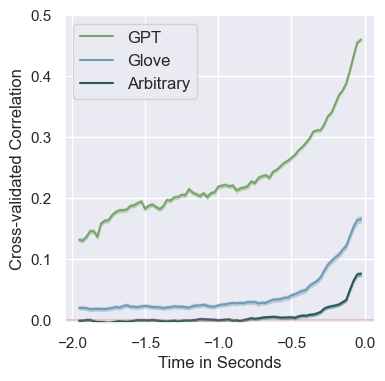

In [55]:
from lingpred_new.plotting import times_100, colours, lowerCI, upperCI

# get model names
models = ['GPT', 'Glove', 'Arbitrary']
labels = models
    
    
fig, (ax1) = plt.subplots(1, 1, figsize=(4, 4))

for i, corr in enumerate([selfpred_GPT, selfpred_Glove, selfpred_arbitrary]):
    ax1.plot(times_100[:78], corr.mean(axis=0)[:78], c=colours[models[i]], label=labels[i])   
    ax1.fill_between(times_100[:78], lowerCI(corr)[:78], upperCI(corr)[:78], color=colours[models[i]], alpha=0.3)

ax1.legend(fontsize=12)
ax1.set_ylim([-0.005, 0.5])
ax1.set_xlabel('Time in Seconds', fontsize=12)
ax1.set_ylabel('Cross-validated Correlation', fontsize=12)
ax1.axhline(c='indianred',  alpha=0.3)
#ax1.set_title(dataset+':' + 'Self-predictability')

plot_split = False
top = 1
fig_path = '../figures/supplementary/' +'Selfpredictability-{}-prediction_split_{}-top_{}.pdf'.format(dataset, plot_split, top)
plt.savefig(fig_path, format='pdf', bbox_inches='tight')

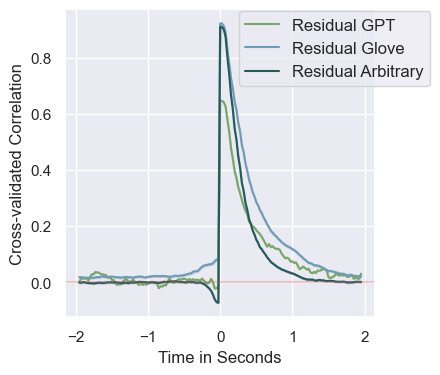

In [58]:
# get model names
models = ['GPT', 'Glove', 'Arbitrary']
labels = ['Residual ' + m for m in models]
    
    
fig, (ax1) = plt.subplots(1, 1, figsize=(4, 4))

for i, corr in enumerate([selfpred_GPT_residualised, selfpred_Glove_residualised, selfpred_arbitrary_residualised]):
    ax1.plot(times_100, corr.mean(axis=0), c=colours[models[i]], label=labels[i])   
    ax1.fill_between(times_100, lowerCI(corr), upperCI(corr), color=colours[models[i]], alpha=0.3)

ax1.legend(loc=(0.56,0.75), fontsize=12)
#ax1.set_ylim([-0.005, 0.05])
ax1.set_xlabel('Time in Seconds', fontsize=12)
ax1.set_ylabel('Cross-validated Correlation', fontsize=12)
ax1.axhline(c='indianred',  alpha=0.3)
#ax1.set_title(dataset+': ' + 'Residualised Self-predictability')

fig_path = '../figures/supplementary/' +'Selfpredictability-{}-regressed_out_True.pdf'.format(dataset)
plt.savefig(fig_path, format='pdf', bbox_inches='tight')


Text(0.5, 1.0, 'Goldstein: Residualised Self-predictability')

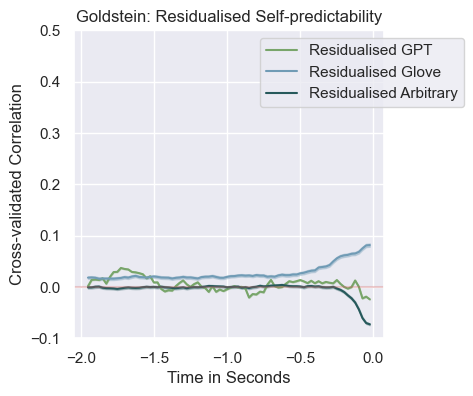

In [43]:
# get model names
models = ['GPT', 'Glove', 'Arbitrary']
labels = ['Residualised ' + m for m in models]
    
    
fig, (ax1) = plt.subplots(1, 1, figsize=(4, 4))

for i, corr in enumerate([selfpred_GPT_residualised, selfpred_Glove_residualised, selfpred_arbitrary_residualised]):
    ax1.plot(times_100[:78], corr.mean(axis=0)[:78], c=colours[models[i]], label=labels[i])   
    ax1.fill_between(times_100[:78], lowerCI(corr)[:78], upperCI(corr)[:78], color=colours[models[i]], alpha=0.3)

ax1.legend(loc=(0.6,0.75))
ax1.set_ylim([-0.1, 0.5])
ax1.set_xlabel('Time in Seconds', fontsize=12)
ax1.set_ylabel('Cross-validated Correlation', fontsize=12)
ax1.axhline(c='indianred',  alpha=0.3)
ax1.set_title(dataset+': ' + 'Residualised Self-predictability')

## Split according to Predictability

In [59]:
y = y_Glove

X_Glove_top_1     = X_Glove[is_top_1]
X_Glove_top_5     = X_Glove[is_top_5]
X_Glove_not_top_1 = X_Glove[is_not_top_1]
X_Glove_not_top_5 = X_Glove[is_not_top_5]

y_top_1     = y[is_top_1]
y_top_5     = y[is_top_5]
y_not_top_1 = y[is_not_top_1]
y_not_top_5 = y[is_not_top_5]

y_top_1 = np.swapaxes(np.swapaxes(y_top_1, 1, 2), 0, 1)
y_top_5 = np.swapaxes(np.swapaxes(y_top_5, 1, 2), 0, 1)
y_not_top_1 = np.swapaxes(np.swapaxes(y_not_top_1, 1, 2), 0, 1)
y_not_top_5 = np.swapaxes(np.swapaxes(y_not_top_5, 1, 2), 0, 1)

In [60]:
# compute the selfpredicatability of the acoustics for each split
selfpred_Glove_top_1     = self_predictability_CVsafe(X_Glove_top_1, y_top_1)
print('2:')
selfpred_Glove_top_5     = self_predictability_CVsafe(X_Glove_top_5, y_top_5)
print('3:')
selfpred_Glove_not_top_1 = self_predictability_CVsafe(X_Glove_not_top_1, y_not_top_1)
print('4:')
selfpred_Glove_not_top_5 = self_predictability_CVsafe(X_Glove_not_top_5, y_not_top_5)

Y should have shape (Dim, Nr_Words, Lags), and has shape (300, 1485, 157)
2:
Y should have shape (Dim, Nr_Words, Lags), and has shape (300, 2604, 157)
3:
Y should have shape (Dim, Nr_Words, Lags), and has shape (300, 3651, 157)
4:
Y should have shape (Dim, Nr_Words, Lags), and has shape (300, 2532, 157)


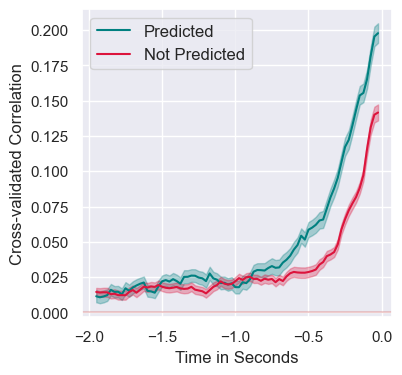

In [61]:

# get model names
models = ['Top 1', 'Not Predicted']
labels = ['Predicted', 'Not Predicted']
    
    
fig, (ax1) = plt.subplots(1, 1, figsize=(4, 4))

for i, key in enumerate([selfpred_Glove_top_1, selfpred_Glove_not_top_1]):
    ax1.plot(times_100[:78], key.mean(axis=0)[:78], c=colours[models[i]], label=labels[i])   
    ax1.fill_between(times_100[:78], lowerCI(key)[:78], 
                                upperCI(key)[:78], color=colours[models[i]], alpha=0.3)

ax1.legend(fontsize=12)
ax1.set_xlabel('Time in Seconds', fontsize=12)
ax1.set_ylabel('Cross-validated Correlation', fontsize=12)
ax1.axhline(c='indianred',  alpha=0.3)
#ax1.set_title(dataset+' Selfpredictability: ' + models[0])

plot_split = True
top = 1
fig_path = '../figures/supplementary/' +'Selfpredictability-{}-prediction_split_{}-top_{}.pdf'.format(dataset, plot_split, top)
plt.savefig(fig_path, format='pdf', bbox_inches='tight')

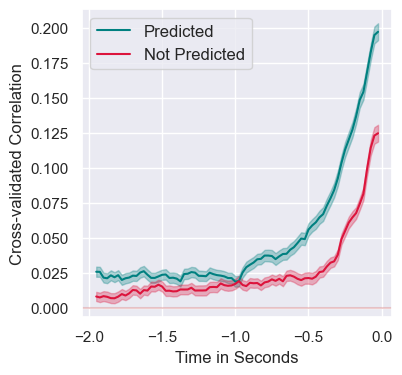

In [62]:

# get model names
models = ['Top 5', 'Not Predicted']
labels = ['Predicted', 'Not Predicted']
    
    
fig, (ax1) = plt.subplots(1, 1, figsize=(4, 4))

for i, key in enumerate([selfpred_Glove_top_5, selfpred_Glove_not_top_5]):
    ax1.plot(times_100[:78], key.mean(axis=0)[:78], c=colours[models[i]], label=labels[i])   
    ax1.fill_between(times_100[:78], lowerCI(key)[:78], 
                                upperCI(key)[:78], color=colours[models[i]], alpha=0.3)

ax1.legend(fontsize=12)
ax1.set_xlabel('Time in Seconds', fontsize=12)
ax1.set_ylabel('Cross-validated Correlation', fontsize=12)
ax1.axhline(c='indianred',  alpha=0.3)
#ax1.set_title(dataset+' Selfpredictability: ' + models[0])

plot_split = True
top = 5
fig_path = '../figures/supplementary/' +'Selfpredictability-{}-prediction_split_{}-top_{}.pdf'.format(dataset, plot_split, top)
plt.savefig(fig_path, format='pdf', bbox_inches='tight')